<a href="https://colab.research.google.com/github/KamilShape/emotion_recognition/blob/main/playwright_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.Photos download**

In [23]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=Error('Connection closed')>
playwright._impl._api_types.Error: Connection closed


In [24]:
!pip install playwright
!playwright install

In [25]:
import requests
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
import random
import os
import numpy as np
from playwright.async_api import async_playwright

In [26]:
def match_span_class(tag):
    parent_span = tag.find_parent('span')
    if parent_span is not None:
        span_classes = parent_span.get('class', [])
        return any(cls.startswith('SummaryItemResponsive') for cls in span_classes)
    return False

In [27]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
faces = ['smiling-person', 'anger-person', 'disgust-person', 'fear-person', 'surprise-person' ]

In [29]:
data_path = 'drive/MyDrive/faces/data'

In [30]:
def get_image(photo_url, path, file_name, face):
  image_response = requests.get(photo_url)
  image_content = image_response.content
  img = Image.open(BytesIO(image_content))
  if img.mode == 'RGB':
    os.makedirs(f'{path}/{face}', exist_ok=True)
    img.save(f'{path}/{face}/{file_name}', 'png')

In [31]:
def get_photos(source, path, face):
  for image in source:
    http = image.find('https://')
    if http != -1:
      file_name = image.split('/')[-1]
      get_image(image, path, file_name, face)

In [18]:
#pages implicated by hand
images = []
for face in faces:
  modified_face = face.replace('-', '%20')
  async def run():
    async with async_playwright() as p:
      browser = await p.chromium.launch()
      page = await browser.new_page()
      await page.goto(f'https://www.istockphoto.com/pl/search/2/image?page=1&phrase={modified_face}') #input pages from 1-100
      # Get the page content
      content = await page.content()
      await browser.close()
      # Use Beautiful Soup to parse the HTML
      soup = BeautifulSoup(content, 'html.parser')
      # Find all image tags and add their src attributes to the image_sources list
      all_images = soup.find_all('img')
      images_in_span = soup.find_all(lambda tag: tag.name == 'img' and match_span_class(tag))
      interesting_images = [img for img in all_images if img not in images_in_span]
      for img in interesting_images:
        src = img.get('src')
        images.append(src)
      get_photos(images, data_path, face)
      print(f"Downloaded {len(images)} photos.")
      print(f"{len(os.listdir(f'{data_path}/{face}'))} photos in {face} folder.")
  images = []
  await run()

Downloaded 61 photos.
60 photos in smiling-person folder.
Downloaded 61 photos.
57 photos in anger-person folder.
Downloaded 61 photos.
59 photos in disgust-person folder.
Downloaded 61 photos.
60 photos in fear-person folder.
Downloaded 61 photos.
60 photos in surprise-person folder.


# **2. Face detection**

In [32]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
def face_recognition(photo, array):
  image = cv2.imread(photo)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  face = face_classifier.detectMultiScale(gray_image, 1.3, 4)
  if len(face) > 0:
   for i, (x, y, w, h) in enumerate(face):
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 255), 2)
      face = image[y:y + h, x:x + w]
      array.append(face)

In [33]:
smiling_faces = []
anger_faces = []
disgust_faces = []
fear_faces = []
surprise_faces  = []

In [34]:
def faces_array(array, photos, path):
  files_folder = os.listdir(f'{path}/{photos}')
  print(f'{path}/{photos}')
  for i in range(0, len(files_folder)):
    img_path = f'{path}/{photos}/{files_folder[i]}'
    face_recognition(img_path, array)

In [35]:
faces_array(smiling_faces, "smiling-person", data_path)
faces_array(anger_faces, "anger-person", data_path)
faces_array(disgust_faces, "disgust-person", data_path)
faces_array(fear_faces, "fear-person", data_path)
faces_array(surprise_faces, "surprise-person", data_path)

drive/MyDrive/faces/data/smiling-person
drive/MyDrive/faces/data/anger-person
drive/MyDrive/faces/data/disgust-person
drive/MyDrive/faces/data/fear-person
drive/MyDrive/faces/data/surprise-person


In [36]:
recognized_faces = {
    'smiling-face': smiling_faces,
    'anger-face' : anger_faces,
    'disgust-face' : disgust_faces,
    'fear-face' : fear_faces,
    'surprise-face' : surprise_faces
}

In [37]:
faces = []
amount = []

for k in recognized_faces:
  faces.append(k)
  amount.append(len(recognized_faces[k]))

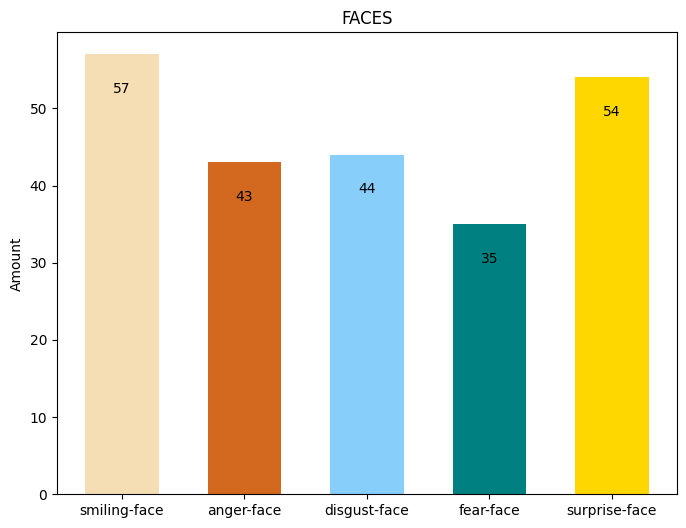

In [40]:
fig, ax = plt.subplots(figsize = (8,6))
colors = ['wheat', 'chocolate', 'lightskyblue','teal', 'gold']
ax.bar(faces, amount, color=colors, width=0.6)
ax.set_title('FACES')
ax.set_ylabel('Amount')

for i in range(0, len(faces)):
  ax.text(faces[i], amount[i] - 5, horizontalalignment='center', s=amount[i] )

# **3. Save faces**

In [41]:
faces_path = 'drive/MyDrive/recognized_faces'

In [42]:
from PIL import Image

for face in recognized_faces:
  os.makedirs(f'{faces_path}', exist_ok=True)
  os.makedirs(f'{faces_path}/{face}', exist_ok=True)
  directory = f'drive/MyDrive/recognized_faces/{face}'
  for i in range(0, len(directory)):
    img = Image.fromarray(recognized_faces[face][i])
    filename = f'{face}_{i}'
    folder = f'drive/MyDrive/recognized_faces/{face}/{filename}.jpeg'
    img.save(folder)

IndexError: ignored